In [2]:
from torchvision import transforms, datasets
import torch

In [3]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [4]:
data_path = "../../myData/p1ch7/cifar/"
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
            transforms.RandomCrop(20),
            # 注意size参数是一个tuple，并且是(h, w)的形式
            # transforms.RandomCrop((20, 30)),
        ]
    ),
)

In [5]:
img, label = cifar10[99]
img.shape

torch.Size([3, 20, 20])

In [6]:
import matplotlib.pyplot as plt

In [7]:
class_name = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

多次运行下面单元格，可以看到每次输出的图像都不一样，也就是说cifar10这个datasets的transform是在每次取出数据时执行的

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 20, 20]) ship


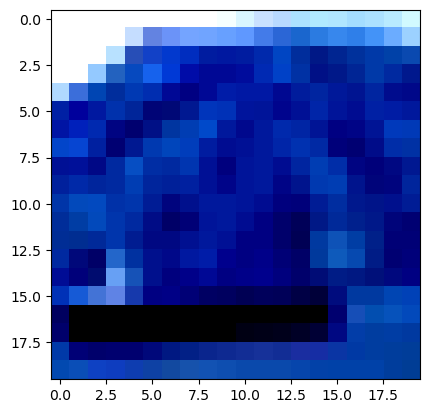

In [8]:
img, label = cifar10[2333]
plt.imshow(img.permute(1, 2, 0))
print(img.shape, class_name[label])
plt.show()

In [9]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
            transforms.RandomCrop(20),
        ]
    ),
)

In [10]:
cifar10_val[0][0].shape

torch.Size([3, 20, 20])

In [11]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [12]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [13]:
len(cifar2), len(cifar2_val)

(10000, 2000)

In [14]:
input_size = 3 * 20 * 20
output_size = 2

In [15]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
deep_model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.Tanh(),
    nn.Linear(128, output_size),
)
loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.SGD(deep_model.parameters(), lr=lr)
n_epochs = 100

In [16]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([64, 3, 20, 20]), torch.Size([64]))

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.view(imgs.shape[0], -1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epochs: {epoch}, Loss: {loss_train / len(train_loader)}")

In [23]:
training_loop(100, optimizer, deep_model, loss_fn, train_loader)

Epochs: 1, Loss: 0.553221089445102
Epochs: 10, Loss: 0.4782050062137045
Epochs: 20, Loss: 0.4321423269760836
Epochs: 30, Loss: 0.3820924249234473
Epochs: 40, Loss: 0.32726630018015573
Epochs: 50, Loss: 0.27620559484715673
Epochs: 60, Loss: 0.2249593216522484
Epochs: 70, Loss: 0.17925945223326895
Epochs: 80, Loss: 0.14521809434814817
Epochs: 90, Loss: 0.11500521343509862
Epochs: 100, Loss: 0.08908937579602193


In [19]:
img, label = cifar2_val[0]
img.is_contiguous()

False

In [20]:
# 测试集准确率
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    # 注意这里的img是一个内存不连续的视图，需要用reshape()来展平
    pred = deep_model(img.reshape(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 0, prediction: bird, label: airplane
index: 1, prediction: bird, label: airplane
index: 2, prediction: bird, label: airplane
index: 3, prediction: airplane, label: bird
index: 4, prediction: bird, label: airplane
index: 5, prediction: airplane, label: bird
index: 6, prediction: bird, label: airplane
index: 8, prediction: airplane, label: bird
index: 15, prediction: bird, label: airplane
index: 16, prediction: bird, label: airplane
index: 17, prediction: bird, label: airplane
index: 18, prediction: bird, label: airplane
index: 21, prediction: airplane, label: bird
index: 22, prediction: airplane, label: bird
index: 27, prediction: airplane, label: bird
index: 28, prediction: airplane, label: bird
index: 29, prediction: bird, label: airplane
index: 33, prediction: bird, label: airplane
index: 34, prediction: bird, label: airplane
index: 35, prediction: bird, label: airplane
index: 40, prediction: airplane, label: bird
index: 41, prediction: bird, label: airplane
index: 42, predict

In [24]:
val_loader = DataLoader(cifar2_val, batch_size=len(cifar2_val), shuffle=True)

In [28]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.view(imgs.shape[0], -1))
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        val_loss = 0.0
        with torch.no_grad():
            for imgs_val, labels_val in val_loader:
                pred = model(imgs_val.view(imgs_val.shape[0], -1))
                loss = loss_fn(pred, labels_val)
                val_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"Epochs: {epoch}, Trainging Loss: {loss_train / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}"
            )

In [26]:
deep_model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.Tanh(),
    nn.Linear(128, output_size),
)
loss_fn = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = optim.SGD(deep_model.parameters(), lr=lr)
n_epochs = 100

In [27]:
training_loop(n_epochs, optimizer, deep_model, loss_fn, train_loader, val_loader)

Epochs: 1, Loss: 0.5504, Validation Loss: 0.5283
Epochs: 10, Loss: 0.4791, Validation Loss: 0.4895
Epochs: 20, Loss: 0.4286, Validation Loss: 0.4805
Epochs: 30, Loss: 0.3786, Validation Loss: 0.4817
Epochs: 40, Loss: 0.3221, Validation Loss: 0.5137
Epochs: 50, Loss: 0.2720, Validation Loss: 0.5927
Epochs: 60, Loss: 0.2194, Validation Loss: 0.5298
Epochs: 70, Loss: 0.1776, Validation Loss: 0.5591
Epochs: 80, Loss: 0.1388, Validation Loss: 0.5715
Epochs: 90, Loss: 0.1084, Validation Loss: 0.6026
Epochs: 100, Loss: 0.0880, Validation Loss: 0.6816


可以很明显地看出，使用了rangomcrop之后，训练出现了overfit的情况，随着training_loss的降低，validation_loss却逐渐增大了

# 2. 变换损失函数，如MSE，训练行为改变了吗

MSE损失函数需要onehot编码

In [70]:
# 先定义一个onehot编码的函数
def label2onehot(labels, output_size):
    assert output_size[0] == labels.shape[0]
    label_onehot = torch.zeros(output_size)
    label_onehot.scatter_(dim=1, index=labels.unsqueeze(1), value=1.0)
    return label_onehot

In [71]:
# 测试onehot编码函数
imgs, labels = next(iter(train_loader))
pred = deep_model(imgs.view(imgs.shape[0], -1))
labels_onehot = label2onehot(labels, pred.shape)
labels_onehot, labels_onehot.shape

(tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1.

In [48]:
from collections import OrderedDict

# 创建一个 OrderedDict 对象
od = OrderedDict()

# 添加元素
od["a"] = 1
od["b"] = 2
od["c"] = 3

# 遍历 OrderedDict

In [58]:
od.items()

odict_items([('a', 1), ('b', 2), ('c', 3)])

In [59]:
for item in od:
    print(item)

a
b
c


In [53]:
seq_model = nn.Sequential(
    OrderedDict(
        [
            ("hidden_linear", nn.Linear(1, 10)),
            ("hidden_activation", nn.Tanh()),
            ("output_linear", nn.Linear(10, 1)),
        ]
    )
)

In [61]:
seq_model.named_parameters()

<generator object Module.named_parameters at 0x000001BE1C1EBE40>

In [60]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([10, 1])
hidden_linear.bias torch.Size([10])
output_linear.weight torch.Size([1, 10])
output_linear.bias torch.Size([1])


In [62]:
seq_model.parameters()

<generator object Module.parameters at 0x000001BE12FAC4A0>

In [64]:
for param in seq_model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.2614],
        [-0.3268],
        [ 0.3495],
        [-0.9398],
        [-0.1445],
        [-0.6706],
        [ 0.3223],
        [ 0.1987],
        [ 0.7149],
        [ 0.8414]], requires_grad=True)
Parameter containing:
tensor([-0.6888, -0.4529,  0.5160,  0.9251,  0.8570,  0.5950,  0.7536, -0.9506,
        -0.1090,  0.6729], requires_grad=True)
Parameter containing:
tensor([[-0.1482, -0.2436, -0.2342, -0.2222, -0.0802,  0.0313, -0.3152,  0.2989,
         -0.1804, -0.1522]], requires_grad=True)
Parameter containing:
tensor([0.0652], requires_grad=True)


In [57]:
seq_model.state_dict().items()

odict_items([('hidden_linear.weight', tensor([[ 0.2614],
        [-0.3268],
        [ 0.3495],
        [-0.9398],
        [-0.1445],
        [-0.6706],
        [ 0.3223],
        [ 0.1987],
        [ 0.7149],
        [ 0.8414]])), ('hidden_linear.bias', tensor([-0.6888, -0.4529,  0.5160,  0.9251,  0.8570,  0.5950,  0.7536, -0.9506,
        -0.1090,  0.6729])), ('output_linear.weight', tensor([[-0.1482, -0.2436, -0.2342, -0.2222, -0.0802,  0.0313, -0.3152,  0.2989,
         -0.1804, -0.1522]])), ('output_linear.bias', tensor([0.0652]))])

In [66]:
for name, param in seq_model.state_dict().items():
    print(name, param.shape)

hidden_linear.weight torch.Size([10, 1])
hidden_linear.bias torch.Size([10])
output_linear.weight torch.Size([1, 10])
output_linear.bias torch.Size([1])


In [47]:
deep_model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0213, -0.0260, -0.0202,  ..., -0.0239, -0.0054, -0.0149],
                      [ 0.0248, -0.0013,  0.0090,  ..., -0.0073,  0.0120,  0.0104],
                      [-0.0041,  0.0028,  0.0315,  ..., -0.0138,  0.0252, -0.0222],
                      ...,
                      [-0.0372, -0.0188, -0.0295,  ...,  0.0044, -0.0060,  0.0197],
                      [-0.0369, -0.0017,  0.0214,  ...,  0.0052, -0.0335, -0.0270],
                      [-0.0275, -0.0020, -0.0125,  ...,  0.0015, -0.0217, -0.0156]])),
             ('0.bias',
              tensor([-0.0178, -0.0029, -0.0842,  0.0673,  0.0145, -0.3133,  0.1582, -0.1165,
                      -0.0184, -0.0148,  0.0027,  0.0973,  0.0141, -0.0988, -0.0025, -0.0738,
                       0.1403,  0.1561, -0.1477, -0.0518, -0.0048,  0.0316,  0.0216,  0.1649,
                       0.1995, -0.1649,  0.0299, -0.3200, -0.1308,  0.0179, -0.0006,  0.1461,
                       0.0241,  0.3456, 

In [75]:
def training_loop(
    n_epochs, optimizer, model, loss_fn, train_loader, val_loader, onehot=False
):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            pred_train = model(imgs.view(imgs.shape[0], -1))
            if onehot:
                labels = label2onehot(labels, pred_train.shape)
            loss = loss_fn(pred_train, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        val_loss = 0.0
        with torch.no_grad():
            for imgs_val, labels_val in val_loader:
                pred_val = model(imgs_val.view(imgs_val.shape[0], -1))
                if onehot:
                    labels_val = label2onehot(labels_val, pred_val.shape)
                loss = loss_fn(pred_val, labels_val)
                val_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"Epochs: {epoch}, Trainging Loss: {loss_train / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}"
            )

In [79]:
deep_model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.Tanh(),
    nn.Linear(128, output_size),
    nn.Softmax(dim=1),  # 需要注意加上softmax层，因为我们的label是onehot编码的
)
loss_fn = nn.MSELoss()
lr = 1e-2
optimizer = optim.SGD(deep_model.parameters(), lr=lr)
n_epochs = 100
training_loop(
    n_epochs, optimizer, deep_model, loss_fn, train_loader, val_loader, onehot=True
)

Epochs: 1, Trainging Loss: 0.1885, Validation Loss: 0.1772
Epochs: 10, Trainging Loss: 0.1641, Validation Loss: 0.1654
Epochs: 20, Trainging Loss: 0.1564, Validation Loss: 0.1617
Epochs: 30, Trainging Loss: 0.1491, Validation Loss: 0.1590
Epochs: 40, Trainging Loss: 0.1415, Validation Loss: 0.1615
Epochs: 50, Trainging Loss: 0.1324, Validation Loss: 0.1542
Epochs: 60, Trainging Loss: 0.1241, Validation Loss: 0.1542
Epochs: 70, Trainging Loss: 0.1151, Validation Loss: 0.1549
Epochs: 80, Trainging Loss: 0.1068, Validation Loss: 0.1573
Epochs: 90, Trainging Loss: 0.0983, Validation Loss: 0.1527
Epochs: 100, Trainging Loss: 0.0898, Validation Loss: 0.1581


In [80]:
# 测试集准确率
n_acc = 0
for i in range(len(cifar2_val)):
    img, label = cifar2_val[i]
    # 注意这里的img是一个内存不连续的视图，需要用reshape()来展平
    pred = deep_model(img.reshape(-1).unsqueeze(0)).argmax()
    if label == pred:
        n_acc += 1
    else:
        print(
            f"index: {i}, prediction: {class_names[pred]}, label: {class_names[label]}"
        )
        # plt.imshow(img.permute(1, 2, 0))
        # plt.show()
print(f"accuracy: {n_acc / len(cifar2_val)}")

index: 2, prediction: bird, label: airplane
index: 4, prediction: bird, label: airplane
index: 7, prediction: bird, label: airplane
index: 9, prediction: airplane, label: bird
index: 11, prediction: bird, label: airplane
index: 14, prediction: airplane, label: bird
index: 28, prediction: airplane, label: bird
index: 35, prediction: bird, label: airplane
index: 36, prediction: airplane, label: bird
index: 37, prediction: airplane, label: bird
index: 39, prediction: bird, label: airplane
index: 42, prediction: bird, label: airplane
index: 52, prediction: bird, label: airplane
index: 53, prediction: airplane, label: bird
index: 57, prediction: bird, label: airplane
index: 70, prediction: airplane, label: bird
index: 78, prediction: bird, label: airplane
index: 79, prediction: bird, label: airplane
index: 83, prediction: airplane, label: bird
index: 84, prediction: airplane, label: bird
index: 89, prediction: bird, label: airplane
index: 90, prediction: bird, label: airplane
index: 91, pre

我这里是把onehot操作独立出来了，视频中是单独实现了MSELoss，然后把onehot操作放在了MSELoss的实现里，感觉确实合理一些。